In [3]:
# Import libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


In [7]:
path_to_td_folder = r"C:\Python310\Lib\site-packages\td"
sys.path.insert(0, path_to_td_folder)
from td.client import TDClient

In [13]:
def grab_price_data():

    # Create a new session
    TDSession = TDClient(account_number = 'adammahdi10@hotmail.com',
                         account_password = 'Yarayara100+',
                         consumer_id = 'FQX83ZV1WGSC0VQRUTNDFR5WDICVMSYM',
                         redirect_uri = 'http://127.0.0.1')

    # Login to the session
    TDSession.login()

        # Defining the list of tickers
        #JPM = JP Morgan, COST = Costco, HD = Home Depot
    list_tickers = ['JPM', 'COST', 'IBM', 'HD', 'ARWR']

    # I need to store multiple result sets.
    price_history = []

    for ticker in list_tickers:

        # Retrieve the daily price history for 1 year
        price_history = TDSession.get_price_history(symbol = ticker, 
                                                    periodType = 'year', 
                                                    period = 2, 
                                                    frequency = 1, 
                                                    frequencyType = 'daily', 
                                                    needExtendedHoursData = False)

        # retrieve candles, and add towards the list.
        for candle in price_history['candles']:
            candle['symbol'] = price_history['symbol']
            price_history.append(candle)

    # put the data to a CSV file, without having an index column
    price_data = pd.DataFrame(price_history).to_csv('price_data.csv', index_label = False)

In [14]:
if os.path.exists('price_data.csv'):

    # Load data from csv file
    price_data = pd.read_csv('price_data.csv')

else:

    # retrieve and store data
    grab_price_data()

    # Load the data
    price_data = pd.read_csv('price_data.csv')

# Display the initial data
price_data.head()

,close,datetime,high,low,open,symbol,volume
0,105.51,1513144800000,107.11,105.48,106.70,JPM,15020293
1,104.66,1513231200000,106.45,104.64,106.12,JPM,13034232
2,106.14,1513317600000,106.52,105.20,105.79,JPM,29350598
3,106.96,1513576800000,107.63,106.48,107.19,JPM,12713148
4,106.51,1513663200000,107.49,106.44,107.35,JPM,12149937


In [16]:
#reorganising data columns
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]
price_data.sort_values(by = ['symbol','datetime'], inplace = True)
price_data['change_in_price'] = price_data['close'].diff()

price_data.head()

,symbol,datetime,close,high,low,open,volume,change_in_price
2016,ARWR,1513144800000,3.40,3.410,3.0100,3.30,2037395,NaN
2017,ARWR,1513231200000,3.15,3.420,3.0500,3.41,1702102,-0.25
2018,ARWR,1513317600000,3.14,3.200,3.0800,3.19,1305646,-0.01
2019,ARWR,1513576800000,3.23,3.395,3.1400,3.15,1254305,0.09
2020,ARWR,1513663200000,3.26,3.380,3.2271,3.25,1128590,0.03


In [17]:
# identifying rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value
price_data[price_data.isna().any(axis = 1)]

,symbol,datetime,close,high,low,open,volume,change_in_price
2016,ARWR,1513144800000,3.40,3.41,3.01,3.30,2037395,NaN
504,COST,1513144800000,188.28,190.12,187.80,188.53,3062856,NaN
1512,HD,1513144800000,183.03,183.67,182.00,182.01,5177363,NaN
1008,IBM,1513144800000,153.91,156.73,153.89,156.60,5661618,NaN
0,JPM,1513144800000,105.51,107.11,105.48,106.70,15020293,NaN


In [18]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970


In [19]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,Prediction
2016,ARWR,1513144800000,3.40,3.4100,3.0100,3.30,2037395,NaN,NaN,NaN,NaN,NaN
2017,ARWR,1513231200000,3.15,3.4200,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,-1.0
2018,ARWR,1513317600000,3.14,3.2000,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,-1.0
2019,ARWR,1513576800000,3.23,3.3950,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,1.0
2020,ARWR,1513663200000,3.26,3.3800,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,1.0
2021,ARWR,1513749600000,3.43,3.5850,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,1.0
2022,ARWR,1513836000000,3.38,3.5398,3.3700,3.40,1105958,-0.05,0.05,0.00,56.223402,-1.0
2023,ARWR,1513922400000,3.71,3.8267,3.4240,3.45,1996695,0.33,0.00,0.33,77.400849,1.0
2024,ARWR,1514268000000,3.79,3.8600,3.6200,3.70,1054488,0.08,0.00,0.08,80.094431,1.0
2025,ARWR,1514354400000,3.84,3.9100,3.7610,3.82,1252920,0.05,0.00,0.05,81.669970,1.0


In [20]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 2520 rows and 12 columns
After NaN Drop we have 2515 rows and 12 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,Prediction
2017,ARWR,1513231200000,3.15,3.420,3.0500,3.41,1702102,-0.25,0.25,0.00,0.000000,-1.0
2018,ARWR,1513317600000,3.14,3.200,3.0800,3.19,1305646,-0.01,0.01,0.00,0.000000,-1.0
2019,ARWR,1513576800000,3.23,3.395,3.1400,3.15,1254305,0.09,0.00,0.09,31.419705,1.0
2020,ARWR,1513663200000,3.26,3.380,3.2271,3.25,1128590,0.03,0.00,0.03,38.813758,1.0
2021,ARWR,1513749600000,3.43,3.585,3.2700,3.29,1378629,0.17,0.00,0.17,64.112604,1.0


In [22]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [23]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  58.34658187599364


In [24]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.525735,0.518116,0.521898,276.000000
Up Day,0.627451,0.634561,0.630986,353.000000
accuracy,0.583466,0.583466,0.583466,0.583466
macro avg,0.576593,0.576338,0.576442,629.000000
weighted avg,0.582819,0.583466,0.583119,629.000000


Accuracy: 0.5834658187599364
Percision: 0.6274509803921569
Recall: 0.6345609065155807
Specificity: 0.5181159420289855


C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


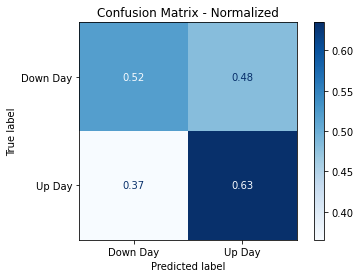

In [25]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


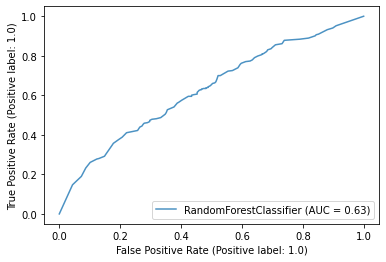

In [27]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

In [28]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.5752916224814422


In [32]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [33]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [35]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')


Correct Prediction (%):  62.79809220985692


,precision,recall,f1-score,support
Down Day,0.525735,0.518116,0.521898,276.000000
Up Day,0.627451,0.634561,0.630986,353.000000
accuracy,0.583466,0.583466,0.583466,0.583466
macro avg,0.576593,0.576338,0.576442,629.000000
weighted avg,0.582819,0.583466,0.583119,629.000000


C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


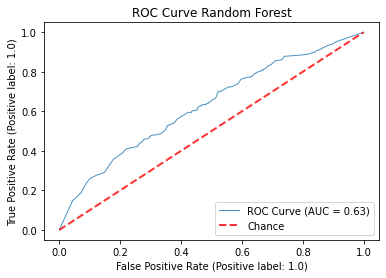

In [36]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()